In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Text_Classification/KP_dataset_df_current.csv')

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow import keras
layers = keras.layers
models = keras.models
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt

import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [4]:
# Create a new pandas dataframe "category_id_df", which only has unique Categories, also sorting this list in order of category_id values
 
category_id_df = df[['Label', 'category_id']].drop_duplicates().sort_values('category_id')



In [5]:
# Create a dictionary ( python datastructure - like a lookup table) that 
# can easily convert category names into category_ids and vice-versa
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Label']].values)

In [6]:
target_names=list(id_to_category.values())

In [7]:
category_to_id

{'Claims': 0,
 'HealthCareDelivery': 1,
 'Membership': 2,
 'Pharmacy': 3,
 'ProductandBenefits': 4,
 'ProviderandNetwork': 5}

In [8]:
# sublinear_df is set to True to use a logarithmic form for frequency
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.LemmatizedcleanText).toarray() 

labels = df.category_id                           # represents the category of each of the documents

In [9]:
features.shape

(141, 4107)

Model Training and Evaluation We will try 3 different classification models on the data : Logistic Regression RandomForestClassifier MultinomialNB ( Naive Bayes)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score

In [11]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0,solver='liblinear',multi_class='ovr'), #default behaior to change in 0.22 version solver='lbfgs', multi_class='auto'
    
]

In [12]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

Run each Algorithm 5 times and store accuracy results in "entries"

In [13]:
#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

In [14]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


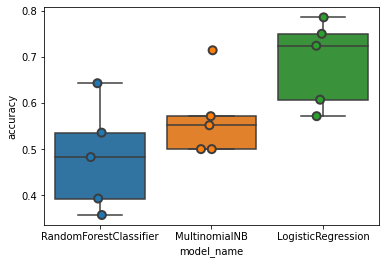

In [15]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [16]:
# Mean accuracy of each algorithm
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.687685
MultinomialNB             0.567488
RandomForestClassifier    0.482266
Name: accuracy, dtype: float64

In [17]:
list(df)

['Label',
 'Text',
 'category_id',
 'cleanText',
 'LemmatizedcleanText',
 'stemmedcleanText',
 'DocName',
 'DocType']

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(df['LemmatizedcleanText']).toarray()
tfidf_df = pd.DataFrame(matrix, columns=vectorizer.get_feature_names())

In [19]:
#feature addition
tfidf_df['text']=df['LemmatizedcleanText'].values

In [20]:
tfidf_df['totalwords'] = tfidf_df['text'].str.split().str.len()

In [21]:
columns_drop = ['text','totalwords']
X_features = tfidf_df.drop(columns_drop,axis=1)

In [22]:
#Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, df['category_id'], test_size=0.2)

In [23]:
#Using Randomforest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)#Using Randomforest

In [24]:
#Print feature importance
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[0:10]

[(0.01836020578519466, 'claim'),
 (0.008394969644985267, 'provider'),
 (0.007128390993448471, 'benefit'),
 (0.006588196427980195, 'membership'),
 (0.006584307979541633, 'plan'),
 (0.006360827911788741, 'coverage'),
 (0.006247916880466398, 'patient'),
 (0.005825237077256935, 'record'),
 (0.005654504915871714, 'demographic'),
 (0.004931911223881908, 'pay')]

In [25]:
y_pred = rf_model.predict(X_test)

from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, y_pred,)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(precision,
                                                        recall,
                                                        round((y_pred==y_test).sum() / len(y_pred),3)))

Precision: [1.         0.66666667 0.33333333 1.         0.45454545 1.        ] / Recall: [0.66666667 0.5        0.66666667 0.66666667 0.625      0.6       ] / Accuracy: 0.621


In [26]:
#GridsearchCV to find best parameters
from sklearn.metrics import precision_recall_fscore_support as score
def train_RF(n_est, depth):
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1)
    rf_model = rf.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    precision, recall, fscore, support = score(y_test, y_pred)
    print('Est: {} / Depth: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        n_est, depth, precision, recall,
        round((y_pred==y_test).sum() / len(y_pred), 3)))
    
for n_est in [10, 50, 100,150]:
    for depth in [10, 20, 30, None]:
        train_RF(n_est, depth) 

Est: 10 / Depth: 10 ---- Precision: [0.66666667 0.5        0.4        0.8        0.45454545 1.        ] / Recall: [0.66666667 0.25       0.66666667 0.66666667 0.625      0.6       ] / Accuracy: 0.586
Est: 10 / Depth: 20 ---- Precision: [0.42857143 0.25       0.5        0.5        0.45454545 1.        ] / Recall: [1.         0.25       0.66666667 0.16666667 0.625      0.2       ] / Accuracy: 0.448
Est: 10 / Depth: 30 ---- Precision: [0.33333333 0.33333333 0.33333333 0.66666667 0.41666667 0.        ] / Recall: [0.33333333 0.25       0.66666667 0.33333333 0.625      0.        ] / Accuracy: 0.379
Est: 10 / Depth: None ---- Precision: [0.5        1.         0.42857143 0.83333333 0.66666667 0.66666667] / Recall: [0.33333333 0.5        1.         0.83333333 0.75       0.4       ] / Accuracy: 0.655
Est: 50 / Depth: 10 ---- Precision: [0.66666667 0.66666667 0.5        0.75       0.5        0.66666667] / Recall: [0.66666667 0.5        0.66666667 0.5        0.75       0.4       ] / Accuracy: 0.58

In [27]:
from sklearn.metrics import classification_report, accuracy_score
print (classification_report(y_test, y_pred,target_names=target_names))

                    precision    recall  f1-score   support

            Claims       1.00      0.67      0.80         3
HealthCareDelivery       0.67      0.50      0.57         4
        Membership       0.33      0.67      0.44         3
          Pharmacy       1.00      0.67      0.80         6
ProductandBenefits       0.45      0.62      0.53         8
ProviderandNetwork       1.00      0.60      0.75         5

          accuracy                           0.62        29
         macro avg       0.74      0.62      0.65        29
      weighted avg       0.73      0.62      0.65        29



In [28]:
rf_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [29]:
# Run MultinomailNB with training data (without k-folds as used earlier)
clf = MultinomialNB().fit(X_train, y_train)

In [30]:
y_pred= clf.predict(X_test)

In [31]:
print (classification_report(y_test, y_pred,target_names=target_names))

                    precision    recall  f1-score   support

            Claims       1.00      0.67      0.80         3
HealthCareDelivery       1.00      0.50      0.67         4
        Membership       0.67      0.67      0.67         3
          Pharmacy       1.00      1.00      1.00         6
ProductandBenefits       0.47      0.88      0.61         8
ProviderandNetwork       1.00      0.20      0.33         5

          accuracy                           0.69        29
         macro avg       0.86      0.65      0.68        29
      weighted avg       0.82      0.69      0.68        29

